In [1]:
import pandas as pd
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Загрузка данных

In [2]:
data = pd.read_excel('data/data_ford_price.xlsx')
data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


In [3]:
data = data[['price','year', 'cylinders', 'odometer', 'lat', 'long', 'weather']]
data.dropna(inplace = True)

y = data['price']
x = data.drop(columns='price')
x.head()

,year,cylinders,odometer,lat,long,weather
0,2016,6,43500,36.471500,-82.483400,59.0
1,2009,8,98131,40.468826,-74.281734,52.0
2,2002,8,201803,42.477134,-82.949564,45.0
3,2000,8,170305,40.764373,-82.349503,49.0
5,2003,8,167662,45.518031,-122.578752,50.0


## Обучение модели

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4682.957


## Отбор признаков

Методы отбора признаков предназначены для уменьшения количества входных переменных до тех значений, которые наиболее полезны для предсказательной способности модели.

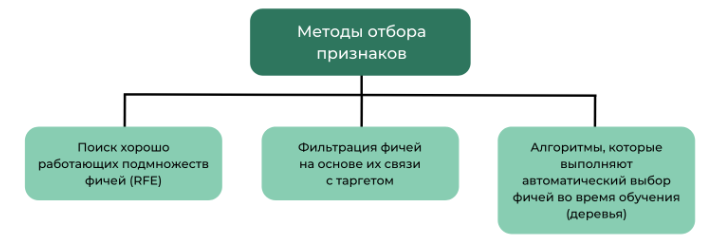

### 1. Удаление скоррелированных признаков

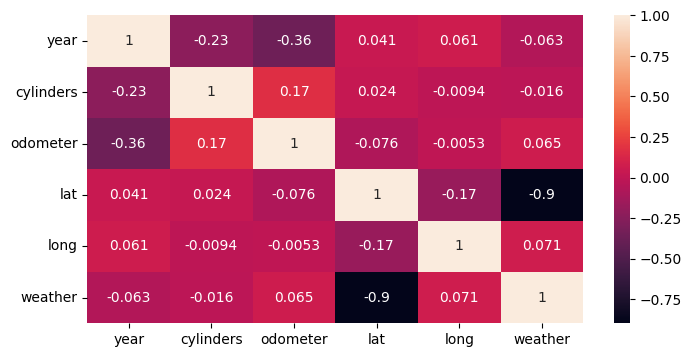

In [5]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.heatmap(x.corr(), annot=True);

In [6]:
x_filtered = x.drop('lat', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(x_filtered, y, test_size=0.3, random_state=40)

In [7]:
model = LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4672.930


### 2. Метод рекурсивного исключения признаков (RFE)

**Метод рекурсивного исключения признаков (RFE)** предполагает выбор признаков путём рекурсивного рассмотрения всё меньших и меньших наборов фичей.

Сначала RFE обучается на изначальной выборке и происходит оценка важности каждого признака. Затем наименее важные фичи удаляются. Эта процедура рекурсивно повторяется на сокращённом наборе до тех пор, пока в конечном итоге не будет достигнуто желаемое количество признаков в выборке.

Выделим три наиболее значимых признака

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
 
columns = selector.get_feature_names_out()
columns

array(['year', 'cylinders', 'lat'], dtype=object)

Также узнаем, как RFE проранжировал все доступные признаки

In [9]:
X_train.columns

Index(['year', 'cylinders', 'odometer', 'lat', 'long', 'weather'], dtype='object')

In [10]:
selector.ranking_

array([1, 1, 4, 1, 3, 2])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x[columns], y, test_size=0.3, random_state=40)

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 5096.570


###  3. Отбор признаков на основе фильтров

В качестве фильтров для выбора признаков используются статистики, такие как коэффициент корреляции Пирсона, ANOVA и т. д. При этом выбор статистических показателей сильно зависит от типов переменных в данных.

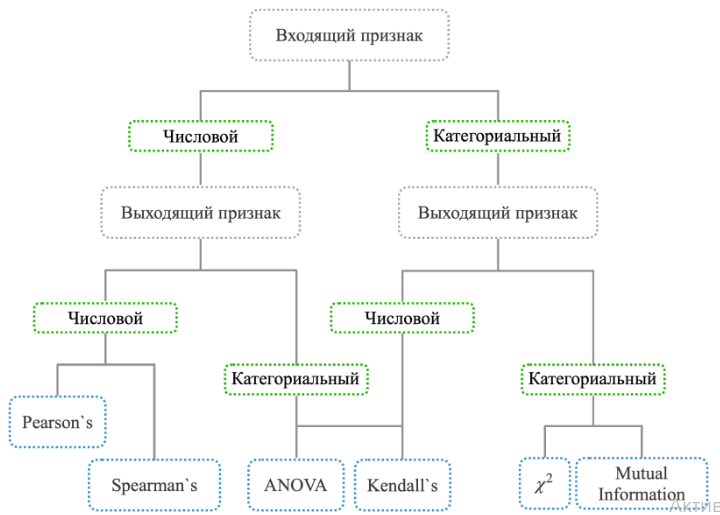

**sklearn** обеспечивает реализацию большинства статистических показателей:
* коэффициент корреляции Пирсона: **f_regression()**;
* дисперсионный анализ ANOVA: **f_classif()**;
* хи-квадрата: **chi2()**;
* взаимная информация: **mutual_info_classif()** и **mutual_info_regression()**.

**SciPy** обеспечивает реализацию многих других статистических данных:
* тау Кендалла (**kendalltau**);
* ранговая корреляция Спирмена (**spearmanr**).

**sklearn** предоставляет методы фильтрации после расчёта статистики для каждой входной переменной с целевой:
* выбор k лучших переменных: **SelectKBest**;
* выбор переменных верхнего процентиля: **SelectPercentile**.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

selector = SelectKBest(f_regression, k=3)
selector.fit(X_train, y_train)
 
columns = selector.get_feature_names_out()
columns

array(['year', 'cylinders', 'odometer'], dtype=object)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x[columns], y, test_size=0.3, random_state=40)

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4708.946


Итого мы получили следующие результаты:

Метод отбора | MAE
--|--
Без отбора | 4682.957
Удаление скоррелированных признаков | 4672.930
RFE | 5096.570
Отбор на основе фильтров | 4708.946

Т.о. улучшение метрики заметно только после удаления признака 'lat', который сильно коррелирует с признаком 'weather'.
Удаление других признаков негативно влияет на качество модели.